In [2]:
import pandas as pd

path = "youtube_comments_climate_change/cleaned_data.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8', index_col=[0])

list(data.columns)

['publishedAt', 'authorName', 'text', 'isReply', 'cleaned']

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

hub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(hub_url)
embeddings = embed(data['cleaned'])

print(embeddings)
print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

tf.Tensor(
[[ 0.02267956 -0.06716511  0.01718922 ... -0.0158857  -0.043926
  -0.00393031]
 [ 0.04192     0.07056528  0.09499479 ... -0.03520851 -0.0134883
   0.04670066]
 [-0.06692986 -0.00541758 -0.03079402 ...  0.02694076 -0.01263959
  -0.07979716]
 ...
 [-0.01887087  0.06309655  0.1051517  ... -0.01325584 -0.04266983
   0.01906748]
 [ 0.01090654 -0.08720968 -0.00068635 ...  0.00569523 -0.01905336
  -0.04718436]
 [ 0.0252452  -0.01673799 -0.06606335 ... -0.00096804 -0.04874956
  -0.04058736]], shape=(25914, 512), dtype=float32)
The embeddings vector is of fixed length 512


In [4]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

# normalize embeddings
embeddings = normalize(embeddings, norm='l2')

# scale embeddings
sc = StandardScaler()
scaled_embeddings = sc.fit_transform(embeddings)

95% cut-off threshold reached with 218 components.


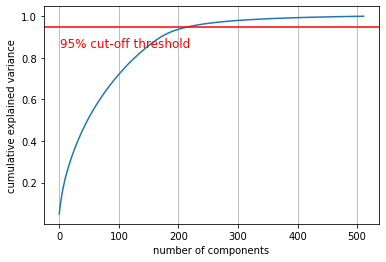

In [9]:
from sklearn.decomposition import PCA
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

pca_cev = PCA().fit(scaled_embeddings)
cev_plot = np.cumsum(pca_cev.explained_variance_ratio_)
plt.plot(cev_plot)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(axis='x')

print("95% cut-off threshold reached with {} components.".format(np.argwhere(cev_plot >= 0.95)[0][0]))

In [10]:
SUBSPACE_DIM = 218

pca = PCA(n_components= SUBSPACE_DIM)
pca_embeddings = pca.fit_transform(scaled_embeddings)

print("Dimensions of embeddings matrix after PCA: ({}, {})".format(pca_embeddings.shape[0], pca_embeddings.shape[1]))

Dimensions of embeddings matrix after PCA: (25914, 218)


In [17]:
from sklearn.decomposition import TruncatedSVD

SUBSPACE_DIM = 218

svd = TruncatedSVD(n_components= SUBSPACE_DIM)
svd_embeddings = svd.fit_transform(embeddings)

print("Dimensions of embeddings matrix after SVD: ({}, {})".format(svd_embeddings.shape[0], svd_embeddings.shape[1]))

Dimensions of embeddings matrix after SVD: (25914, 218)


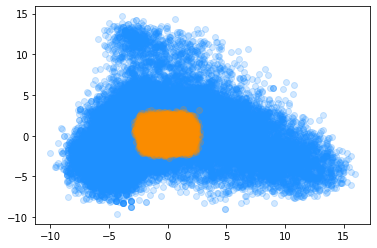

In [20]:
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], color = "dodgerblue", alpha=0.2)
plt.scatter(scaled_embeddings[:, 0], scaled_embeddings[:, 1], color = "darkorange", alpha=0.2)

In [23]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

sse_pca, db_pca, slc_pca = {}, {}, {}
for k in range(20, 125, 5):
    kmeans_pca = KMeans(n_clusters = k, max_iter=1000, random_state=10).fit(pca_embeddings)
    clusters_pca = kmeans_pca.labels_
    sse_pca[k] = kmeans_pca.inertia_
    db_pca[k] = davies_bouldin_score(pca_embeddings, clusters_pca)
    slc_pca[k] = silhouette_score(pca_embeddings, clusters_pca)

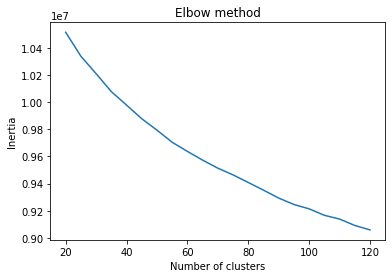

In [24]:
plt.plot(list(sse_pca.keys()), list(sse_pca.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.show()

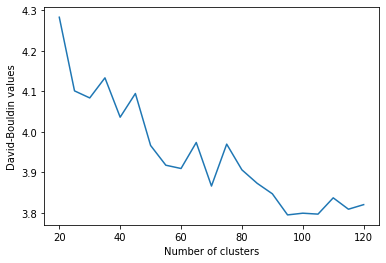

In [25]:
plt.plot(list(db_pca.keys()), list(db_pca.values()))
plt.xlabel("Number of clusters")
plt.ylabel("David-Bouldin values")
plt.show()

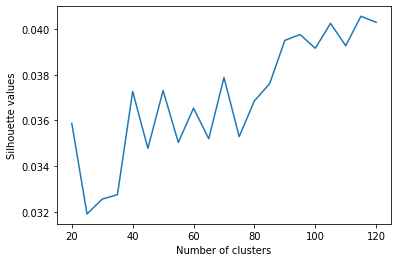

In [27]:
plt.plot(list(slc_pca.keys()), list(slc_pca.values()))

plt.xlabel("Number of clusters")
plt.ylabel("Silhouette values")
plt.show()

In [32]:
import umap
reducer2 = umap.UMAP(n_components = 2,min_dist = .5)

embeddings_umap2 = reducer2.fit_transform(pca_embeddings)
embeddings_umap2.shape

(25914, 2)

In [33]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

clustering = DBSCAN(eps=3, min_samples=2).fit(embeddings_umap2)

labels = clustering.labels_
data["labels"] = labels
# measure the performance of dbscan algo
#Identifying which points make up our “core points”
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[clustering.core_sample_indices_] = True
print(core_samples)
#Calculating "the number of clusters"
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(embeddings_umap2, labels))

[ True  True  True ...  True  True  True]
3
Silhouette Coefficient: 0.386


In [35]:
metrics.silhouette_score(embeddings_umap2, labels)

0.38605833

Text(0.5, 0.98, 'Clustering with DBSCAN')

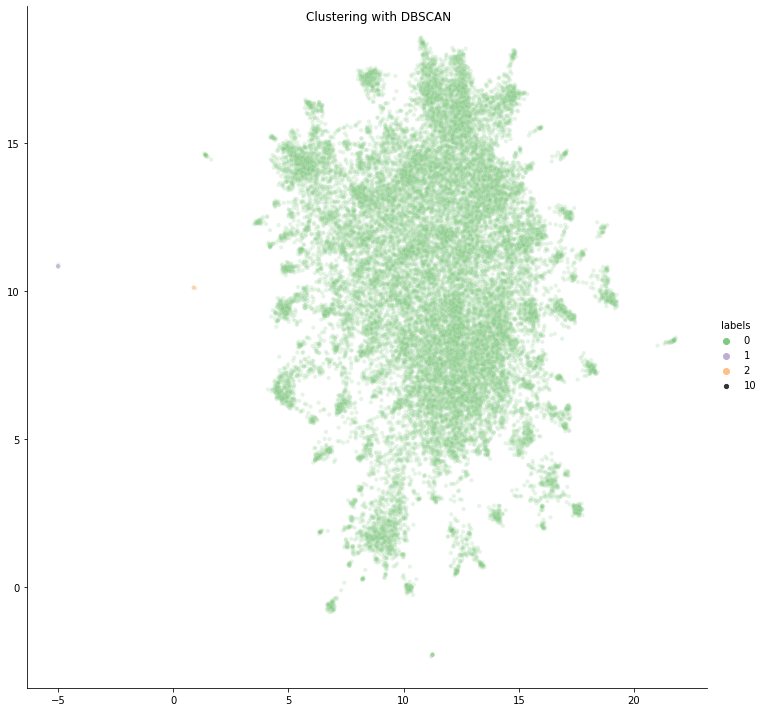

In [34]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2

plot = sns.relplot(x = embeddings_umap2[:, 0], y = embeddings_umap2[:, 1], size = 10, hue = data["labels"], palette = palette_param,alpha = alpha_param,height = 10)
plot.fig.suptitle('Clustering with DBSCAN')